<a href="https://colab.research.google.com/github/TaeMD/ML-projects/blob/main/Covid19_Pneumonia_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/education454/datasets.git

Cloning into 'datasets'...
remote: Enumerating objects: 2301, done.
remote: Total 2301 (delta 0), reused 0 (delta 0), pack-reused 2301
Receiving objects: 100% (2301/2301), 1.31 GiB | 29.12 MiB/s, done.
Checking out files: 100% (2295/2295), done.


In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

In [3]:
base_dir = '/content/datasets/Data'
train_dir = os.path.join (base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
train_covid = os.path.join(base_dir, 'train/COVID19')
train_normal = os.path.join(base_dir, 'train/NORMAL') 
test_covid = os.path.join(base_dir, 'test/COVID19')
test_normal = os.path.join(base_dir, 'test/NORMAL')

In [4]:
normal_length = len(os.listdir(train_normal))
covid_length = len(os.listdir(train_covid))

print('train normal cases:', len(os.listdir(train_normal)))
print('train covid cases:', len(os.listdir(train_covid)))
print('test normal cases:', len(os.listdir(test_normal)))
print('test covid cases:', len(os.listdir(test_covid)))

train normal cases: 1266
train covid cases: 545
test normal cases: 317
test covid cases: 167


# Split the train data into train and validation data manually (Optional) 

Normal train data into train and validation data

In [ ]:
nsplit = int(normal_length * 0.8)
csplit = int(covid_length * 0.8)
print(nsplit)
print(csplit)

In [ ]:
normal_file_list = os.listdir(train_normal)

In [ ]:
random.shuffle(normal_file_list)

train_normal_file_list = normal_file_list [:nsplit]
validation_normal_file_list = normal_file_list [nsplit:]
print(len(train_normal_file_list))
print(len(validation_normal_file_list))

In [ ]:
validation_dir = base_dir + '/validation'
validation_normal_dir = validation_dir + '/NORMAL'
validation_covid_dir = validation_dir + '/COVID19'

os.mkdir(validation_dir)
os.mkdir(validation_normal_dir)
os.mkdir(validation_covid_dir)

In [ ]:
for f in validation_normal_file_list:
  os.rename (os.path.join(base_train_normal,f), os.path.join(validation_normal_dir,f))

In [ ]:
len(os.listdir(validation_normal_dir))

Covid train data into train and validation data

In [ ]:
covid_file_list = os.listdir(train_covid)

In [ ]:
len(covid_file_list)

In [ ]:
random.shuffle(covid_file_list)

train_covid_file_list = covid_file_list [:csplit]
validation_covid_file_list = covid_file_list [csplit:]
print(len(train_covid_file_list))
print(len(validation_covid_file_list))

In [ ]:
for f in validation_covid_file_list:
  os.rename (os.path.join(train_covid, f), os.path.join(validation_covid_dir, f))

In [ ]:
len(os.listdir(validation_covid_dir))

# Data visualization

In [5]:
train_normal_files = os.listdir(train_normal)
train_covid_files = os.listdir(train_covid)

In [6]:
os.path.join(train_covid, train_covid_files[1])
os.path.join(train_normal, train_normal_files[10])

'/content/datasets/Data/train/NORMAL/NORMAL(1506).jpg'

In [ ]:
fig, ax = plt.subplots (2,2, figsize=(10,10))

ax[0,0].imshow(load_img(os.path.join(train_covid, train_covid_files[1])))
ax[0,1].imshow(load_img(os.path.join(train_covid, train_covid_files[2])))
ax[1,0].imshow(load_img(os.path.join(train_normal, train_normal_files[10])))
ax[1,1].imshow(load_img(os.path.join(train_normal, train_normal_files[30])))

In [7]:
def show_picture(n):
  fig, axes = plt.subplots (2,n, figsize = (15,10))
  fig.tight_layout(pad=2.0)

  for i, ax in enumerate(axes.flatten()):
    if i <= n-1:
      ax.imshow(load_img(os.path.join(train_normal, train_normal_files[i])))
      ax.set_title(os.path.join(train_normal, train_normal_files[i]).split('/')[-1])
      ax.axis('Off')
    else:
      ax.imshow(load_img(os.path.join(train_covid, train_covid_files[i])))
      ax.set_title(os.path.join(train_covid, train_covid_files[i]).split('/')[-1])
      ax.axis('Off')

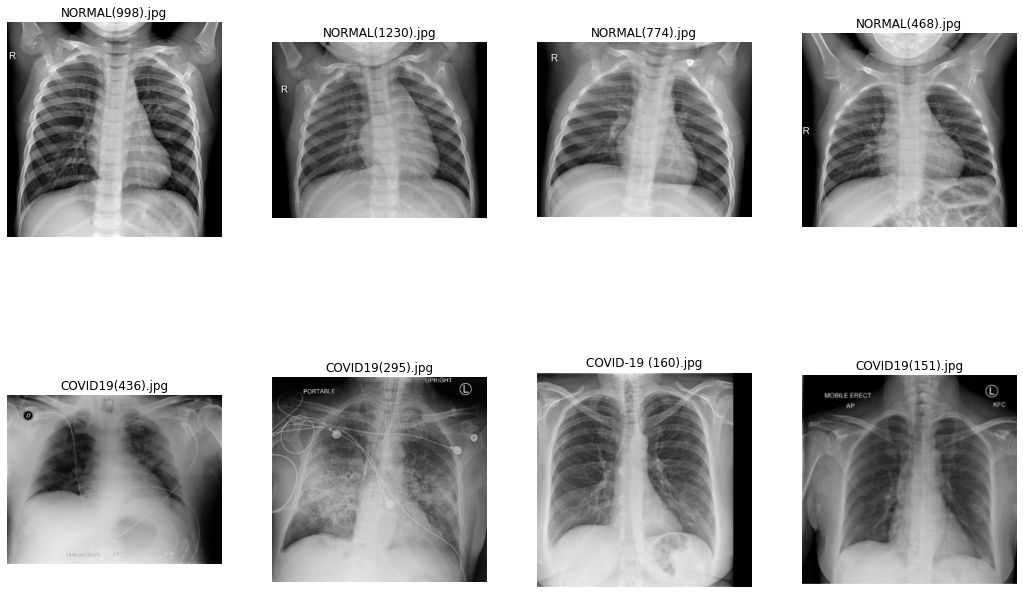

In [8]:
show_picture(4)

# Data Augmentation and Normalization

In [9]:
train_gen = ImageDataGenerator(rescale = 1./255, 
                               rotation_range=20, 
                               width_shift_range=0.2, 
                               height_shift_range=0.2, 
                               shear_range=0.2, 
                               zoom_range=0.2,
                               fill_mode='nearest', 
                               validation_split=0.2)

validation_gen = ImageDataGenerator(rescale=1./255)

test_gen = ImageDataGenerator(rescale = 1./255.0)

train_generator = train_gen.flow_from_directory(train_dir, target_size=(150, 150), 
                                                class_mode='binary', subset = 'training', batch_size=32)

validation_generator = train_gen.flow_from_directory(train_dir, target_size=(150, 150), 
                                                class_mode='binary', subset = 'validation', batch_size=32)

test_generator = test_gen.flow_from_directory(test_dir, target_size=(150, 150), 
                                                class_mode='binary', batch_size=32)

Found 1449 images belonging to 2 classes.
Found 362 images belonging to 2 classes.
Found 484 images belonging to 2 classes.


In [10]:
print(train_generator.image_shape)
print(train_generator.class_indices)

(150, 150, 3)
{'COVID19': 0, 'NORMAL': 1}


# Build CNN model

In [32]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 36, 36, 64)       

In [38]:
model.fit_generator(train_generator, epochs=40, validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/40
46/46 [==============================] - 55s 1s/step - loss: 0.0705 - accuracy: 0.9779 - val_loss: 0.0849 - val_accuracy: 0.9724
Epoch 2/40
46/46 [==============================] - 54s 1s/step - loss: 0.0717 - accuracy: 0.9779 - val_loss: 0.0947 - val_accuracy: 0.9724
Epoch 3/40
46/46 [==============================] - 53s 1s/step - loss: 0.0649 - accuracy: 0.9765 - val_loss: 0.0883 - val_accuracy: 0.9669
Epoch 4/40
46/46 [==============================] - 53s 1s/step - loss: 0.0697 - accuracy: 0.9745 - val_loss: 0.0862 - val_accuracy: 0.9807
Epoch 5/40
46/46 [==============================] - 53s 1s/step - loss: 0.0657 - accuracy: 0.9793 - val_loss: 0.0786 - val_accuracy: 0.9834
Epoch 6/40
46/46 [==============================] - 53s 1s/step - loss: 0.0583 - accuracy: 0.9814 - val_loss: 0.0989 - val_accuracy: 0.9641
Epoch 7/40
46/46 [==============================] - 53s 1s/step - loss: 0.0750 - accuracy: 0.9800 - val_loss: 0.0903 - val_accuracy: 0.9696
Epoch 8/40
46/46 [==

In [ ]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
plt.plot(acc)
plt.plot(val_acc)
plt.legend(['training', 'validation'])
plt.xlabel('epoch')
plt.title('accuracy')
plt.show()

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['training', 'validation'])
plt.xlabel('epoch')
plt.title('loss')
plt.show()

In [41]:
test_loss, test_accuracy = model.evaluate (test_generator)
print(f"test loss: {test_loss} and test accuracy: {test_accuracy}")

16/16 [==============================] - 12s 718ms/step - loss: 0.0615 - accuracy: 0.9793
test loss: 0.061512239277362823 and test accuracy: 0.9793388247489929
